In [2]:
import pandas as pd
import numpy as np
from random import shuffle
from scipy.linalg import svd
import matplotlib.pyplot as plt

# Load the data
rawdata = pd.read_csv("activity_train.csv", header=None, names=['ProteinID', 'ChemblID', 'Activity'])

# Function to create the ranking matrix
def create_rankingMatrix(rowLabel, colLabel, df):
    rows = list(set(df[rowLabel])) 
    cols = list(set(df[colLabel])) 
    n_rows = len(rows)
    n_cols = len(cols)

    rows = dict(zip(rows, np.arange(n_rows)))
    cols = dict(zip(cols, np.arange(n_cols)))
    mat = np.zeros((n_rows, n_cols))
    for rw in df.values:
        mat[rows[rw[0]], cols[rw[1]]] = rw[2]
    return mat, rows, cols

mat, mat_rows, mat_cols = create_rankingMatrix('ProteinID', 'ChemblID', rawdata)
mat = mat.T
pd.DataFrame(mat)

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Function to initialize P, Q, and biases
def make_init_PQ(U, S, V, k):
    Uk  = U[:, :k] 
    Sk  = S[:k]
    Sdk = np.diag(Sk)
    Vk  = V[:k, :]
    P   = Uk.copy() #!
    Q   = (Sk*Vk.T).transpose()
    return P,Q

# Function to initialize biases
def initialize_biases(R):
    global_bias = np.mean(R[R > 0])
    bu = np.zeros(R.shape[0])
    bi = np.zeros(R.shape[1])
    
    for u in range(R.shape[0]):
        user_ratings = R[u, R[u] > 0]
        if len(user_ratings) > 0:
            bu[u] = np.mean(user_ratings) - global_bias
    
    for i in range(R.shape[1]):
        item_ratings = R[R[:, i] > 0, i]
        if len(item_ratings) > 0:
            bi[i] = np.mean(item_ratings) - global_bias
    
    return global_bias, bu, bi

mask = 1 * (mat > 0)
sum_ = np.sum(mask)

# Function to calculate error with biases
def calc_error(R, P, Q, bu, bi, global_bias):
    predicted = global_bias + bu[:, np.newaxis] + bi[np.newaxis, :] + P @ Q
    return np.sum((R - predicted)**2 * mask) / sum_

# Function to run one epoch of SGD with regularization and biases
def run_epoch_reg(elems, R, P, Q, bu, bi, global_bias, LR, Lp=1, Lq=1, Lbu=0.1, Lbi=0.1):
    shuffle(elems)
    for u, i in elems:
        r_ui = R[u, i]
        pred = global_bias + bu[u] + bi[i] + P[u, :] @ Q[:, i]
        error = r_ui - pred

        bu[u] += LR * (error - Lbu * bu[u])
        bi[i] += LR * (error - Lbi * bi[i])
        P[u, :] += LR * (error * Q[:, i] - Lp * P[u, :])
        Q[:, i] += LR * (error * P[u, :] - Lq * Q[:, i])
    return P, Q, bu, bi

# Function to perform SGD for recommendation systems with biases
def RecSys_SGD(R, num_epochs=100, k=2, LR=0.01, Lp=0.5, Lq=0.5, Lbu=0.1, Lbi=0.1, output_mses=False):
    MSEs = []
    U, S, V = svd(R, full_matrices=False)
    P, Q = make_init_PQ(U, S, V, k)
    
    # Initialize biases
    global_bias, bu, bi = initialize_biases(R)
    
    rated_elements = [(u, i) for u, i in np.argwhere(R > 0)]
    
    for i in range(num_epochs):
        P, Q, bu, bi = run_epoch_reg(rated_elements, R, P, Q, bu, bi, global_bias, LR, Lp, Lq, Lbu, Lbi)
        mse = calc_error(R, P, Q, bu, bi, global_bias)
        MSEs.append(mse)
        
    if not output_mses:
        return P, Q, bu, bi
    else:
        return P, Q, bu, bi, MSEs

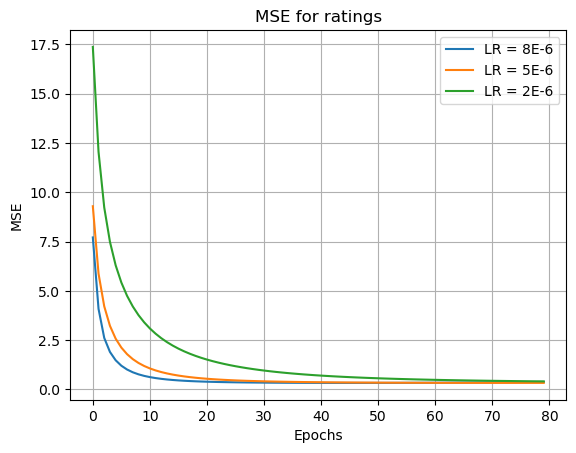

In [6]:
P, Q, bu, bi, mses1 = RecSys_SGD(mat, num_epochs=80, k=80, LR=0.000008, Lp=0.5, Lq=0.5, output_mses=True)
P, Q, bu, bi, mses2 = RecSys_SGD(mat, num_epochs=80, k=80, LR=0.000005, Lp=0.5, Lq=0.5, output_mses=True)
P, Q, bu, bi, mses3 = RecSys_SGD(mat, num_epochs=80, k=80, LR=0.000002, Lp=0.5, Lq=0.5, output_mses=True)

plt.plot(mses1, label="LR = 8E-6")
plt.plot(mses2, label="LR = 5E-6")
plt.plot(mses3, label="LR = 2E-6")
plt.grid()
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("MSE for ratings")
plt.show()

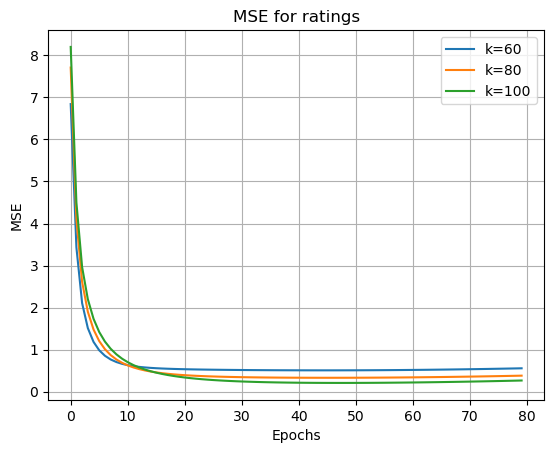

In [21]:
best_LR=0.000008
P, Q, bu, bi, mses4 = RecSys_SGD(mat, num_epochs=80, k=60, LR=best_LR, Lp=0.5, Lq=0.5, output_mses=True)
P, Q, bu, bi, mses5 = RecSys_SGD(mat, num_epochs=80, k=100, LR=best_LR, Lp=0.5, Lq=0.5, output_mses=True)

plt.plot(mses4, label="k=60")
plt.plot(mses1, label="k=80")
plt.plot(mses5, label="k=100")
plt.grid()
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("MSE for ratings")
plt.show()

In [15]:
# Grid search for the best Lp and Lq
best_k = 100

P, Q, bu, bi, mse_1 = RecSys_SGD(mat, num_epochs=80, k=best_k, LR=best_LR, Lp=0.1, Lq=0.1, output_mses=True)
P, Q, bu, bi, mse_2 = RecSys_SGD(mat, num_epochs=80, k=best_k, LR=best_LR, Lp=0.1, Lq=0.3, output_mses=True)
P, Q, bu, bi, mse_3 = RecSys_SGD(mat, num_epochs=80, k=best_k, LR=best_LR, Lp=0.1, Lq=0.5, output_mses=True)

P, Q, bu, bi, mse_4 = RecSys_SGD(mat, num_epochs=80, k=best_k, LR=best_LR, Lp=0.3, Lq=0.1, output_mses=True)
P, Q, bu, bi, mse_5 = RecSys_SGD(mat, num_epochs=80, k=best_k, LR=best_LR, Lp=0.3, Lq=0.3, output_mses=True)
P, Q, bu, bi, mse_6 = RecSys_SGD(mat, num_epochs=80, k=best_k, LR=best_LR, Lp=0.3, Lq=0.5, output_mses=True)

P, Q, bu, bi, mse_7 = RecSys_SGD(mat, num_epochs=80, k=best_k, LR=best_LR, Lp=0.5, Lq=0.1, output_mses=True)
P, Q, bu, bi, mse_8 = RecSys_SGD(mat, num_epochs=80, k=best_k, LR=best_LR, Lp=0.5, Lq=0.3, output_mses=True)
P, Q, bu, bi, mse_9 = RecSys_SGD(mat, num_epochs=80, k=best_k, LR=best_LR, Lp=0.5, Lq=0.5, output_mses=True)

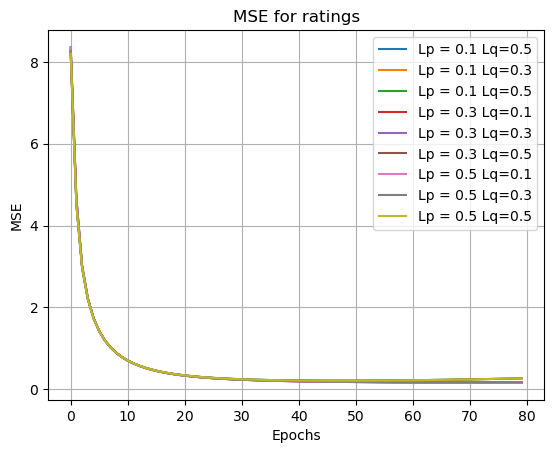

In [17]:
plt.plot(mse_1, label="Lp = 0.1 Lq=0.5")
plt.plot(mse_2, label="Lp = 0.1 Lq=0.3")
plt.plot(mse_3, label="Lp = 0.1 Lq=0.5")

plt.plot(mse_4, label="Lp = 0.3 Lq=0.1")
plt.plot(mse_5, label="Lp = 0.3 Lq=0.3")
plt.plot(mse_6, label="Lp = 0.3 Lq=0.5")

plt.plot(mse_7, label="Lp = 0.5 Lq=0.1")
plt.plot(mse_8, label="Lp = 0.5 Lq=0.3")
plt.plot(mse_9, label="Lp = 0.5 Lq=0.5")
plt.grid()
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("MSE for ratings")
plt.show()

In [21]:
# List of MSE lists
mse_lists = [mse_1, mse_2, mse_3, mse_4, mse_5, mse_6, mse_7, mse_8, mse_9]

# Initialize variables to track the minimum MSE and its list index
min_mse = float('inf')
min_mse_list_index = -1
min_mse_epoch = -1

# Iterate through each MSE list and find the minimum MSE value and its list index
for idx, mse_list in enumerate(mse_lists):
    current_min_mse = min(mse_list)
    current_min_epoch = mse_list.index(current_min_mse)
    if current_min_mse < min_mse:
        min_mse = current_min_mse
        min_mse_list_index = idx
        min_mse_epoch = current_min_epoch

print(f"Minimum MSE: {min_mse}")
print(f"Found in list: mse_{min_mse_list_index + 1}")
print(f"At epoch: {min_mse_epoch}")

Minimum MSE: 0.15107181320320687
Found in list: mse_7
At epoch: 79


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


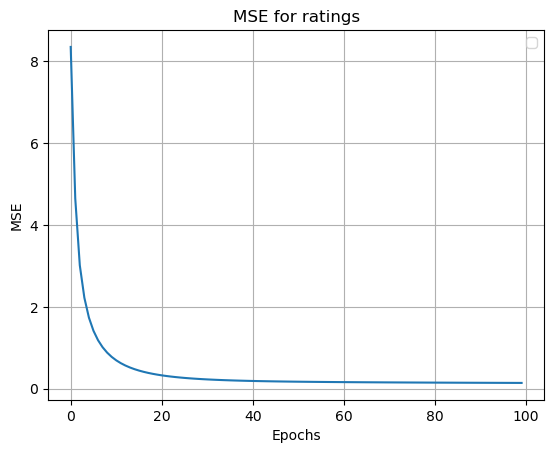

In [23]:
best_Lp = 0.5
best_Lq = 0.1
P, Q, bu, bi, mses = RecSys_SGD(mat, num_epochs=100, k=best_k, LR=best_LR, Lp=best_Lp, Lq=best_Lq, output_mses=True)
plt.plot(mses)
plt.grid()
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("MSE for ratings")
plt.show()

In [25]:
#get the number of epochs to get the minumum mse value
epochs = 0
mse_value = mses[0]
for i in range(len(mses)):
    if mses[i] < mse_value:
        epochs = i

print(epochs)

99


In [30]:
# Load test data
testdata = pd.read_csv("activity_test_blanked.csv", header=None, names=['ProteinID', 'ChemblID', 'Activity'])
mat2, mat2_rows, mat2_cols = create_rankingMatrix('ProteinID', 'ChemblID', testdata)
mat2 = mat2.T
pd.DataFrame(mat2)

# Calculate the predicted values using the trained P, Q, and biases
def predict_ratings(P, Q, bu, bi, global_bias):
    return global_bias + bu[:, np.newaxis] + bi[np.newaxis, :] + np.dot(P, Q)

media = np.mean(mat[mat > 0])

# Use the function to get the predicted ratings
predicted_matrix = predict_ratings(P, Q, bu, bi, media)
# Extract the predicted values for the test data
test_predictions = []
for _, row in testdata.iterrows():
    protein_id = row['ProteinID']
    chembl_id = row['ChemblID']
    if protein_id in mat_rows and chembl_id in mat_cols:
        u = mat_rows[protein_id]
        i = mat_cols[chembl_id]
        pred = predicted_matrix[i, u]
        if pred < 1:
            test_predictions.append(1)
        else:
            test_predictions.append(pred)
    else:
        test_predictions.append(1)

# Create a copy of the test data DataFrame
test_data_with_predictions = testdata.copy()

# Add the predictions to the copied DataFrame
test_data_with_predictions['Activity'] = test_predictions

# Save the predictions to a CSV file
test_data_with_predictions.to_csv("PD_PREDS-10.csv", index=False, header=False)
